In [2]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [5]:
dirpath = 'SMAI-Dataset-release/IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


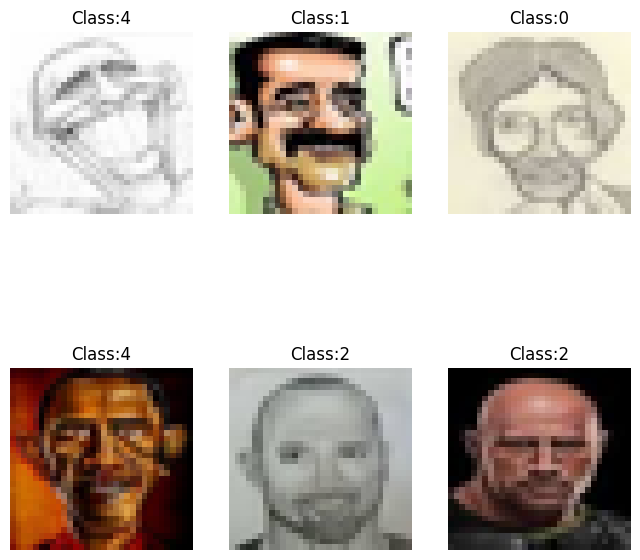

(672, 32, 32, 3)


In [6]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)
print(X.shape)

1.1

In [8]:
class PCA:
    def __init__(self,components):
        self.data = None
        self.components = components
        self.sorted_eig_val = None
        self.eig_vec = None
        self.eig_val = None
        self.transformed_data = None

    def fit(self):
        cov_mat = np.cov(self.data)
        self.eig_val, self.eig_vec = np.linalg.eig(cov_mat)

        self.eig_val = np.real(self.eig_val)
        self.eig_vec = np.real(self.eig_vec)
        
        self.sorted_eig_val = np.argsort(self.eig_val)[::-1]
        sorted_eig_val_sliced = self.sorted_eig_val[:self.components]
        eig_vec_sliced = self.eig_vec[:,sorted_eig_val_sliced]
        self.transformed_data = np.dot(eig_vec_sliced.T, self.data)
        self.transformed_data = self.transformed_data.T
       
        #return self.transformed_data
    
    def transform(self,X):
        mat = []
        for l in range(X.shape[0]):
            flat = X[l].flatten()
            mat.append(flat)

        #print(mat)  
        
        mat = np.array(mat)
        mat = mat.T
        mean = np.mean(mat,axis=1)
        mean = np.reshape(mean,(-1,1))
        mat = mat - mean
        self.data = mat

    def cumvar(self):
        sum = np.real(np.sum(self.eig_val))
        y_axis = [] 
        x_axis = []

        for i in range(1, self.data.shape[0] + 1):
            x_axis.append(i)
            sorted_eig_val_sliced = self.sorted_eig_val[:i]
            
            eigen_values = self.eig_val[sorted_eig_val_sliced]
            cum_sum = np.cumsum(eigen_values)
            y_axis.append(np.real(cum_sum[-1])/sum) 

        plt.bar(x_axis,y_axis)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.show()

    def preprocess(self, x):
        x = x - np.mean(x, axis=0)
        self.data = x.T

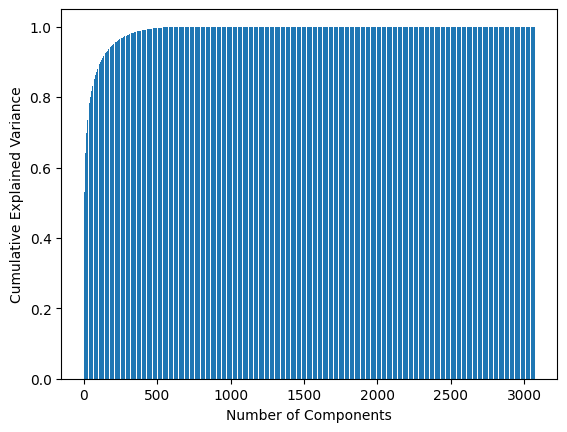

In [82]:
pca = PCA(100)
pca.transform(X)
pca.fit()
pca.cumvar()

Pictionary dataset

In [100]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

def Knn(x_train, x_test, y_train, y_test):
    prediction_default = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
    prediction_default.fit(x_train, y_train)
    pred = prediction_default.predict(x_test)
    val = y_test

    return accuracy_score(val, pred)
    # print(accuracy_score(val, pred))
    # print(f1_score(val, pred, average='macro'))
    # print(precision_score(val, pred, average='macro', zero_division=0))
    # print(recall_score(val, pred, average='macro', zero_division=0))

In [88]:
from sklearn.model_selection import train_test_split

data = np.load('data.npy', allow_pickle=True)
np.random.shuffle(data)
label = data[:, 3]
data = np.delete(data, 3, axis=1)
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

train_data_new = []
for train in x_train:
    train_data_new.append(train[2][0])

validation_data_new = []
for validation in x_test:
    validation_data_new.append(validation[2][0])

print("Before PCA")
acc = Knn(train_data_new, validation_data_new, y_train, y_test)
print("Accuracy: ", acc)

print()
print("After PCA")

pca_pic = PCA(512)
pca_pic.transform(data[:, 2])
pca_pic.fit()
Z = pca_pic.transformed_data

li = []
for i in range(1, 513):
    x_train, x_test, y_train, y_test = train_test_split(Z[:, :i], label, test_size=0.2)
    acc = Knn(x_train, x_test, y_train, y_test)
    li.append(acc)

sorted_li = sorted(enumerate(li), key=lambda x: x[1], reverse=True)
sorted_li = sorted_li[:10]

for i in sorted_li:
    print("Accuracy: ", i[1], "Components: ", i[0])

Before PCA
Accuracy:  0.22

After PCA
Accuracy:  0.30333333333333334 Components:  152
Accuracy:  0.2966666666666667 Components:  267
Accuracy:  0.2866666666666667 Components:  300
Accuracy:  0.2833333333333333 Components:  143
Accuracy:  0.2833333333333333 Components:  193
Accuracy:  0.28 Components:  168
Accuracy:  0.28 Components:  198
Accuracy:  0.27666666666666667 Components:  57
Accuracy:  0.27666666666666667 Components:  69
Accuracy:  0.27666666666666667 Components:  107


##### Accuracy before PCA after PCA is almost the same

Accuracy vs principal components

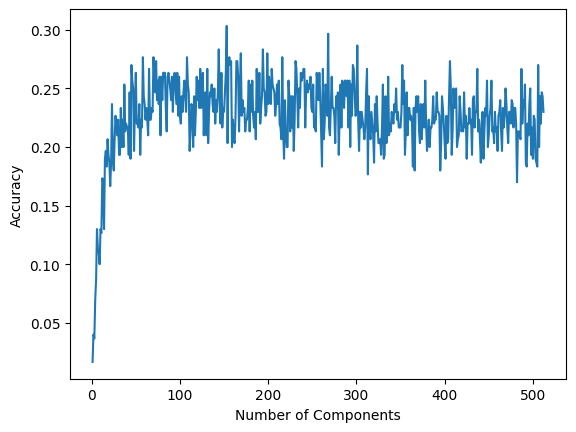

In [89]:
plt.plot(range(1, 513), li)
plt.title('PCA for pictionary dataset')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()

IIIT-CFW Dataset

In [101]:
from sklearn.model_selection import train_test_split

pca_iiit = PCA(3072)

pca_iiit.transform(X)
pca_iiit.fit()
Z = pca_iiit.transformed_data

li_iiit = []
for i in range(1, 3073):
    x_train, x_test, y_train, y_test = train_test_split(Z[:, :i], y, test_size=0.2, random_state=42)
    acc = Knn(x_train, x_test, y_train, y_test)
    li_iiit.append(acc)

sorted_li_iiit = sorted(enumerate(li_iiit), key=lambda x: x[1], reverse=True)
sorted_li_iiit = sorted_li_iiit[:10]

for i in sorted_li_iiit:
    print("Accuracy: ", i[1], "Components: ", i[0])

Accuracy:  0.5111111111111111 Components:  33
Accuracy:  0.5037037037037037 Components:  22
Accuracy:  0.5037037037037037 Components:  25
Accuracy:  0.5037037037037037 Components:  32
Accuracy:  0.5037037037037037 Components:  40
Accuracy:  0.4962962962962963 Components:  26
Accuracy:  0.4962962962962963 Components:  27
Accuracy:  0.4962962962962963 Components:  34
Accuracy:  0.4962962962962963 Components:  36
Accuracy:  0.4962962962962963 Components:  38


Accuracy vs principal components

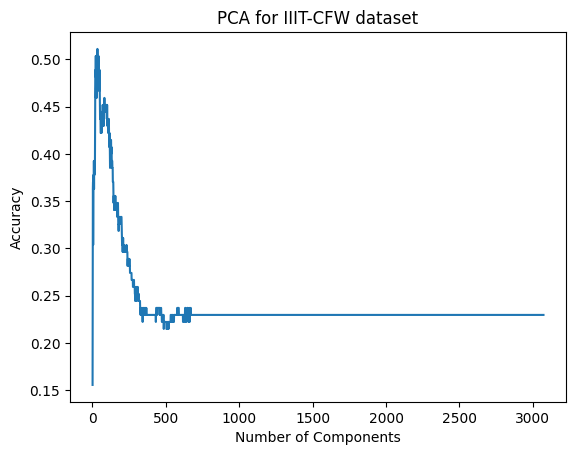

In [102]:
plt.plot(range(1, 3073), li_iiit)
plt.title('PCA for IIIT-CFW dataset')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()

1.2

Drawer

(100, 8)


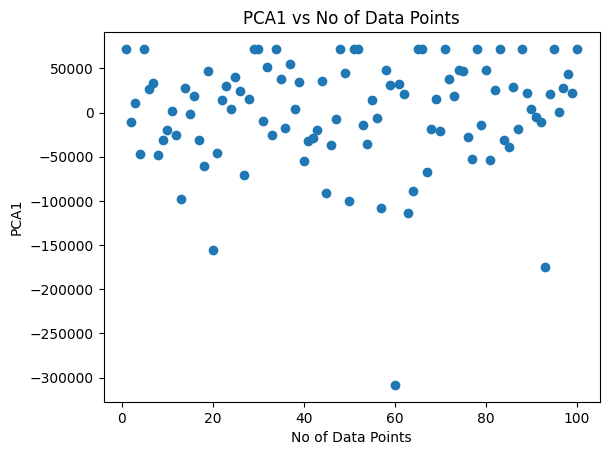

In [9]:
import pandas as pd

drawer_data = pd.read_csv('drawer_attributes.csv')
drawer_data = drawer_data.drop(['d_drawer'], axis=1)

pca_drawer = PCA(drawer_data.shape[1])
pca_drawer.preprocess(drawer_data)
pca_drawer.fit()
comp = pca_drawer.transformed_data

#plot data wrt principal components
x = []
for i in range(1, drawer_data.shape[0] + 1):
    x.append(i)

print(comp.shape)
plt.title('PCA1 vs No of Data Points')
plt.scatter(x, comp[:, 0])
plt.xlabel('No of Data Points')
plt.ylabel('PCA1')
plt.show()

[-2.10955385e+00  1.30225443e+00 -2.17898967e+00 -2.78418513e+00
 -2.10955385e+00 -3.84047264e+00  4.37830674e-01 -7.65611849e-01
 -1.69796616e+00 -3.13448311e-01 -1.23199711e+00  1.40279072e+00
 -4.34106287e+00  1.06447238e-01  5.37862342e+00 -2.63890525e+00
 -3.59307184e+00 -1.17352408e-02  3.61426848e+00 -4.65656024e+00
 -6.59979184e+00 -8.27576082e-01  3.38268865e-01 -1.44173860e+00
  3.51886895e+00  5.93508326e-01  8.06863495e+00 -1.82999909e+00
 -2.10955385e+00 -2.10955385e+00  6.27500671e+00  9.80076527e-02
 -3.32607644e+00 -2.10955385e+00 -5.20050257e-01  7.64701204e+00
  9.20618865e-01 -2.08198546e-02  4.91612610e-01 -6.66339771e+00
 -4.94257058e+00 -1.62457038e+00  1.35442253e+01 -3.17237265e+00
 -1.19593317e+00 -3.80199476e+00 -7.70783082e-01 -2.10955385e+00
 -3.50058206e+00  1.74257290e-01 -2.10955385e+00 -2.10955385e+00
  2.05988866e-01 -2.91576670e+00  3.66095490e+00  1.99448230e+00
 -1.61240703e+00 -4.44284817e+00  1.37519696e+00  2.84351153e+00
  2.19039537e+00 -6.09392

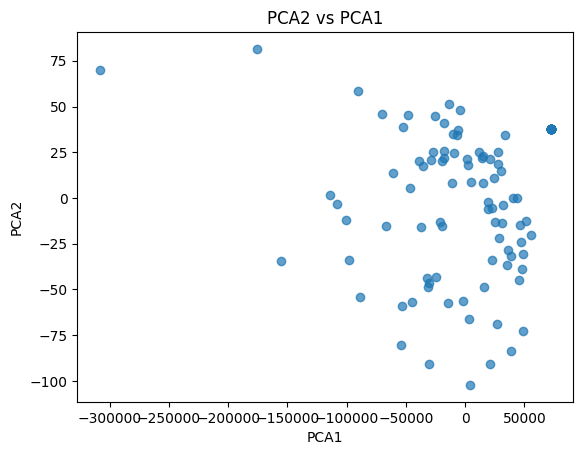

In [69]:
plt.title('PCA2 vs PCA1')
plt.scatter(comp[:, 0], comp[:, 1], alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

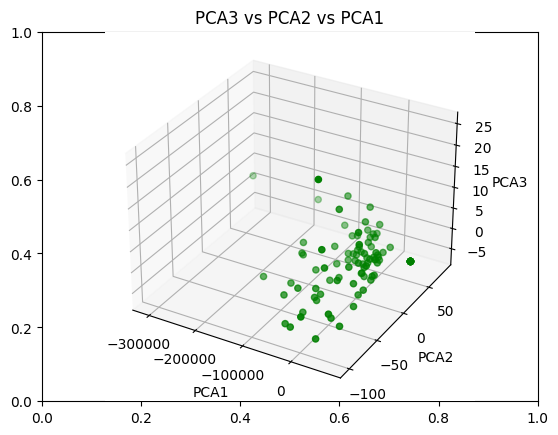

In [67]:
plt.title('PCA3 vs PCA2 vs PCA1')
ax = plt.axes(projection ="3d")
ax.scatter3D(comp[:, 0], comp[:, 1], comp[:, 2],  color = "green")
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

Guesser

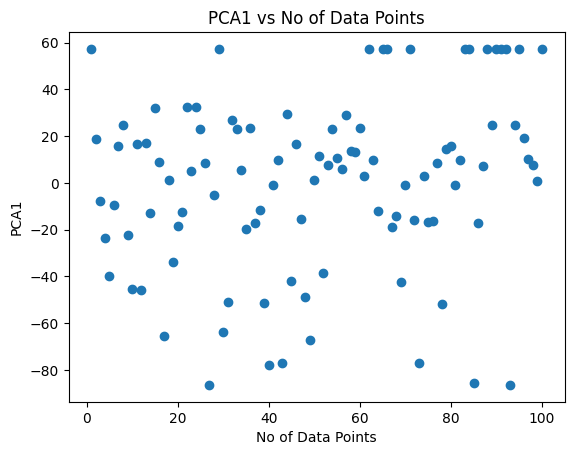

In [70]:
guesser_data = pd.read_csv('guesser_attributes.csv')
guesser_data = guesser_data.drop(['g_guesser'], axis=1)

pca_guesser = PCA(guesser_data.shape[1])
pca_guesser.preprocess(guesser_data)
pca_guesser.fit()
comp = pca_guesser.transformed_data

x = []
for i in range(1, guesser_data.shape[0] + 1):
    x.append(i)

plt.title('PCA1 vs No of Data Points')
plt.scatter(x, comp[:, 0])
plt.xlabel('No of Data Points')
plt.ylabel('PCA1')
plt.show()

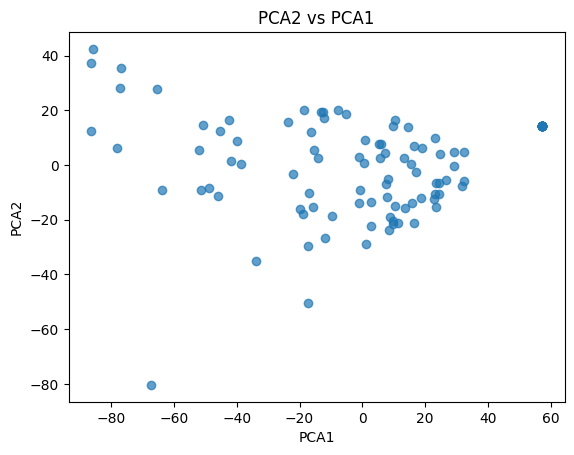

In [71]:
plt.title('PCA2 vs PCA1')
plt.scatter(comp[:, 0], comp[:, 1], alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

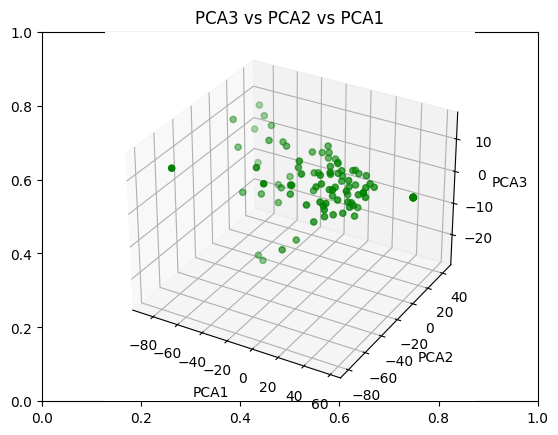

In [72]:
plt.title('PCA3 vs PCA2 vs PCA1')
ax = plt.axes(projection ="3d")
ax.scatter3D(comp[:, 0], comp[:, 1], comp[:, 2],  color = "green")
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

- Principal Component Analysis (PCA):
  - Reduces the dimensions of a dataset by creating new axes.
  - These new axes are called principal components (PCs) and are arranged by decreasing variance.
  - PC1 captures the main data variation and represents the primary trend in the original feature space.
  - PC2, orthogonal (perpendicular) to PC1, represents the second-highest variation.
  - PC3 is the third-most variable direction and is orthogonal to both PC1 and PC2.
  - This pattern continues for higher-numbered PCs, all of which are mutually orthogonal.
  - Collectively, the principal components offer a comprehensive view of the data's variance in its original feature space.